In [34]:
from __future__ import print_function
import pandas as pd
import os,sys
import pybedtools as pbt
from StringIO import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from mapper import expand, parse_mapping_table, apply_mappers

root_dir = "/home/olya/SFU/Hossein/v2/"
preprocessed_dir = root_dir+"preprocessed/mutations/"
w = 0.05
%matplotlib inline

### Converting mutations to gene-level score (-1;1)
* differentiate TSG and OG
    
    We use two lists of TSG and OG and their driver mutations obtained from OncoKB:
    

* differentiate mutations by their potential effect
    
    We take into consideration a protential effect of all mutations in every altered gene proposed based on 
        - type of protein change
        - proximity to known driver mutations

#### TSG potential loss-of-function 
    *-1 if any truncating variant found 
    *-1/(x+1) if any variant found at the distance x of database LoF
#### OG potential gain-of-function 
    * +1 if any variant match the position of database GoF variant 
    * +1/(x+1) if any variant found at the distance x of database GoF
    * However, some genes annotated as TSG and OG in COSMIC. If such a gene has a truncating variant, it gets -1. If such gene has a truncating variant, we exclude it from the consideration. 
    * Many OG are activated via overexpression or apmplification, but not via somatic mutations. We exclude such OG from consideration, because it is impossible to propose the effect of a mutation in such OGs. Every OG has at least one mutation
    
### Sources of mutations
We need:
    * a list of genes labelled as TSG or OG 
    * a list of driver mutations or hotspots with protein coordinates 
    
1). COSMIC CGC - 1). list of driver genes, classified as TSG, OG or fusions; Tiers 1 and 2  2). list of mutations in these genes in every sample included in COSMIC

2). OncoKB - curated list of 1) driver genes and 2) mutations with effects.

3). Bailey et al. 2018 Cell "Comprehensive Characterization
of Cancer Driver Genes and Mutation" - they report only driver genes with any mutations or hotspots. 

4). Iorio et al. 2016 - 

5). cBioPortal - 1D https://www.cancerhotspots.org and 3D hotspots https://www.3dhotspots.org.


# Workflow

1). Mutations - union of 1D and 3D hotspots 
2). List of genes:
    * TSG: union of Bailey et al. 2018 and OncoKB
    * OG: genes from union of Bailey et al., 2018 and OncoKB OG lists which had any mutation hotspot
3). Mutation classification by effect on protein:
    * potential LoF: frameshift,nonsense,ess_splice,stop_lost
    * potential GoF: missense, inframe indels



In [35]:
# from http://oncokb.org/#/cancerGenes
OncoKB_mut = pd.read_csv("../../hotspots/OncoKB/allAnnotatedVariants.tsv",sep ="\t")
OncoKB_gtype = pd.read_csv("../../hotspots/OncoKB/OncoKB_gene_type.txt",sep ="\t")
OncoKB_gtype = OncoKB_gtype[['Hugo Symbol ', u'Oncogene /TSG ']]
OncoKB = {"OG":'Oncogene ',"TSG":'TSG ',"OG_TSG":'Oncogene,TSG '}
for key in OncoKB.keys():
    OncoKB[key] = set(map(str.rstrip, list(set(OncoKB_gtype.loc[OncoKB_gtype['Oncogene /TSG ']== OncoKB[key],'Hugo Symbol '].values))))

OncoKB["OG"].update(OncoKB["OG_TSG"])
OncoKB["TSG"].update(OncoKB["OG_TSG"]) 
print("OncoKB OG:",len(OncoKB["OG"]),"TSG:",len(OncoKB["TSG"]),"OG_TSG:",len(OncoKB["OG_TSG"]))

OncoKB OG: 214 TSG: 246 OG_TSG: 25


### Algorithm:



In [36]:
# gene_id - Entrez Gene ID 
# df - all mutations in sample
#    columns: "aa_pos","function", "Entrez_gene_ID"
# hotspots - table of known hotsport  "Entrez_gene_ID" and "aa_pos"

def distance_to_hotspot(gene_id,df_gene, hotspots):
    '''Returns minimal distance between point mutation in gene and known hotspot'''
    # consider only GoF because LoF affect the whole protein and not a certian point
    df_gene = df_gene.loc[df_gene["function"] == "point_mutation"]
    df_hotspots = hotspots.loc[hotspots["Entrez_gene_ID"] == gene_id, :]
    dist = 100000
    for s,e in set(df_gene["aa_pos"].values):
        for hs, he in set(df_hotspots["aa_pos"].values):
            dist = min(dist, abs(s-hs),abs(s-he), abs(e-hs), abs(e-he))
    return dist

def mutations2score(df,TSG,OG,hotspots, w=0.05,verbose = False):
    # define gene type
    gene_scores = {}
    for gene_id in list(set(df["Entrez_gene_ID"].values)):
        df_gene = df.loc[df["Entrez_gene_ID"] == gene_id, :]
        # functions of mutations
        mut_functions = set(df_gene["function"].values)
        if gene_id in TSG:
            # check for truncating mutations:
            # score is -1 if any
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] =-1
            else:
                # in mutation is not truncating, 
                # get the distance to closets hotspot if any 
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                # set abs. maximal of 1/(dist+1) and 2w which corresponds LoF in unannotatedd gene
                gene_scores[gene_id] = -max(1.0/(dist+1),2*w)
        elif gene_id in OG:
            if "point_mutation" in mut_functions:
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                if "truncating_mutation" in mut_functions:
                    if verbose:
                        print("GoF at dist",dist,"from hotspot in Oncogene with GoF",file = sys.stderr)
                        print(df_gene,file = sys.stderr)
                    if 1.0/(dist+1) > 2*w:
                        # if there is a mutation close to hotspot
                        # despite LoF it is likely a driver and the second copy of this gene is broken
                        # this happens in sampl 905968  in PIK3CA gene (5290)
                        gene_scores[gene_id] = 1.0/(dist+1)
                    else:
                        # otherwise we set -1 to differentiate it from neutral mutations
                        # because oncogene might turn on after domain truncation
                        gene_scores[gene_id] = -1
                else:
                    # non-hotspot mutation in non-LoF oncogene - small positive value
                    gene_scores[gene_id] = max(1.0/(dist+1),w)
            else:
                # only LoF mutations, oncogene is likely not functional or
                # it is turned-on after truncting mutations
                # therefore we set -1 to differentiate it from neutral mutations
                gene_scores[gene_id] = -1
            
            
        else: # if unknown_significance
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] = -2.0*w
            else:
                gene_scores[gene_id] = -w
    
    return pd.Series(gene_scores)

In [37]:
bailye = {"OG":[],"TSG":[],"OG_TSG":[]}
bailye_drivers = pd.read_excel("../../hotspots/Bailey_2018.mmc1.xlsx", sheet_name="Table S1", 
                               skiprows = 3)
bailye_drivers = bailye_drivers[["Gene","Tumor suppressor or oncogene prediction (by 20/20+)"]]
#print(bailye_drivers.shape[0])
bailye_drivers.drop_duplicates(inplace=True)
bailye_drivers.columns = ["gene", "role"]
#print(bailye_drivers.shape[0])
bailye_drivers.fillna("NA", inplace = True)
bailye_drivers["role"] = bailye_drivers["role"].apply(lambda x: x.replace("possible ",""))
bailye_drivers.drop_duplicates(inplace=True)
#print(bailye_drivers.shape[0])
bailye_drivers.loc[bailye_drivers.duplicated("gene", keep=False),:]
#print(len(set(bailye_drivers["gene"].values)))
bailye["OG"] = bailye_drivers.loc[bailye_drivers["role"] == "oncogene",:]
bailye["OG"] = set(bailye["OG"]["gene"].values)
bailye["TSG"] = bailye_drivers.loc[bailye_drivers["role"] == "tsg",:]
bailye["TSG"] = set(bailye["TSG"]["gene"].values)
bailye["OG_TSG"] = bailye["OG"].intersection(bailye["TSG"])
print("Bailey_2018 OG:",len(bailye["OG"]),"TSG:",len(bailye["TSG"]),"both:", len(bailye["OG_TSG"]))
#print(len(OncoKB["OG"]),len(OncoKB["TSG"]),len(OncoKB["OG_TSG"]) ) 

Bailey_2018 OG: 115 TSG: 162 both: 18


# Hotspots 

In [38]:
hotspots2D_subst = pd.read_excel("../../hotspots/hotspots_v2.xls","24K_hotspots_cancerhotspots-org_singlecodon")
hotspots2D_indels = pd.read_excel("../../hotspots/hotspots_v2.xls","24K_hotspots_cancerhotspots-org_indels")
print("1D mutations",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )
hotspots2D_subst = hotspots2D_subst.loc[~hotspots2D_subst["Amino_Acid_Position"].str.contains("splice")]
hotspots2D_subst = hotspots2D_subst[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_subst.drop_duplicates(inplace=True)
hotspots2D_indels = hotspots2D_indels[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_indels.drop_duplicates(inplace=True)
print("1D hotspots",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )
cBioPortal_muts = pd.concat([hotspots2D_subst,hotspots2D_indels],axis =0)
cBioPortal_muts_ = cBioPortal_muts.loc[cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts = cBioPortal_muts.loc[~cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts["Amino_Acid_Position"] = cBioPortal_muts["Amino_Acid_Position"].apply(int)
#cBioPortal_muts["start"] = cBioPortal_muts["Amino_Acid_Position"]
#cBioPortal_muts["end"] = cBioPortal_muts["Amino_Acid_Position"]
cBioPortal_muts["aa_pos"] = cBioPortal_muts["Amino_Acid_Position"].apply(lambda x : (x,x))

#cBioPortal_muts_ ["start"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[0]))
#cBioPortal_muts_["end"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[1]))
cBioPortal_muts_["aa_pos"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x : tuple(map(int,x.split("-"))))

cBioPortal_muts = pd.concat([cBioPortal_muts_,cBioPortal_muts],axis = 0)
cBioPortal_muts["source"] = "1D"


### 3D

cBioPortal_3D = pd.read_excel("../../hotspots/3d_hotspots.xls","Table S5")
cBioPortal_3D = cBioPortal_3D[["Gene","Amino_Acid_Position"]]
print("3D mutations",cBioPortal_3D.shape[0])
cBioPortal_3D.drop_duplicates(inplace=True)
print("3D hotspots ",cBioPortal_3D.shape[0])
cBioPortal_3D["Amino_Acid_Position"] = cBioPortal_3D["Amino_Acid_Position"].apply(int)
#cBioPortal_3D["start"] = cBioPortal_3D["Amino_Acid_Position"]
#cBioPortal_3D["end"] = cBioPortal_3D["Amino_Acid_Position"]
cBioPortal_3D["aa_pos"] = cBioPortal_3D["Amino_Acid_Position"].apply(lambda x : (x,x))
cBioPortal_3D.rename({"Gene":'Hugo_Symbol'}, axis="columns",inplace=True)
cBioPortal_3D["source"] = "3D"
cBioPortal_muts = cBioPortal_muts[["Hugo_Symbol","aa_pos"]]
cBioPortal_3D = cBioPortal_3D[["Hugo_Symbol","aa_pos"]]
cBioPortal_muts = pd.concat([cBioPortal_3D, cBioPortal_muts],axis=0)
cBioPortal_muts.sort_values(["Hugo_Symbol"],ascending = True,inplace=True)

cBioPortal_genes = set(cBioPortal_muts["Hugo_Symbol"].values)
print("genes with hotspot",len(cBioPortal_genes))
cBioPortal_muts = cBioPortal_muts[["Hugo_Symbol","aa_pos"]]
cBioPortal_muts.drop_duplicates(inplace=True)
print("unique hotspots",cBioPortal_muts.shape[0])
#cBioPortal_muts

1D mutations 3004 495
1D hotspots 1024 55
3D mutations 9512
3D hotspots  3395
genes with hotspot 688
unique hotspots 4258


In [39]:
print("genes with and without mutations")
for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind].intersection(cBioPortal_genes) 
    b = bailye[kind].intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),"/",len(OncoKB[kind]),
         "Bailye_2018", len(b),"/",len(bailye[kind]))

genes with and without mutations
OG oncokb 110 / 214 Bailye_2018 81 / 115
TSG oncokb 123 / 246 Bailye_2018 81 / 162
OG_TSG oncokb 15 / 25 Bailye_2018 14 / 18


In [40]:
for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind]#.intersection(cBioPortal_genes) 
    b = bailye[kind]#.intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),
         "Bailye_2018", len(b),"union",len(b.union(oncokb)),
         "mutated:",
         len(b.union(oncokb).intersection(cBioPortal_genes)))

OG oncokb 214 Bailye_2018 115 union 277 mutated: 144
TSG oncokb 246 Bailye_2018 162 union 316 mutated: 136
OG_TSG oncokb 25 Bailye_2018 18 union 41 mutated: 28


In [21]:
# TSG - not necessarity with a hotspot, take union of OncoKB and  Bailye_2018
TSG = OncoKB["TSG"].union(bailye["TSG"])
# OG - must have a hotspot 
OG = OncoKB["OG"].union(bailye["OG"]).intersection(cBioPortal_genes)
print("TSG:",len(TSG),"with hotspots:",len(TSG.intersection(cBioPortal_genes)),
      "\nOG with hotspots:",len(OG))
# list of hotspots: 
hotspots = cBioPortal_muts.loc[cBioPortal_muts["Hugo_Symbol"].isin(OG|TSG),:]
print("Hotspots (all from cBioPortal):", cBioPortal_muts.shape[0],
      "\n\ton OG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(OG)].shape[0],
      "\n\ton TSG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(TSG)].shape[0])
hotspots.head(5)

TSG: 316 with hotspots: 136 
OG with hotspots: 144
Hotspots (all from cBioPortal): 4258 
	on OG: 1116 
	on TSG: 1012


,Hugo_Symbol,aa_pos
1456,ACVR1,"(206, 206)"
1307,ACVR1,"(258, 258)"
1128,ACVR1,"(328, 328)"
2542,ACVR1B,"(398, 398)"
2056,ACVR1B,"(401, 401)"


### map gene name to Entrez gene ID 

In [24]:
NCBI = pd.read_csv(root_dir+"Homo_sapiens.gene_info",sep = "\t")
NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
16 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
59266 Symbol can be mapped directly to GeneID


In [25]:
ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 
ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3145 Synonyms mapped to multiple GeneID
49179 different Synonyms mapped to the same GeneID
10839 Synonyms can be mapped directly to GeneID


In [26]:
tsg_og_gene_names = pd.DataFrame.from_dict({"genes":dict(zip(list(OG | TSG),list(OG | TSG)))})
tsg_og_gene_names, query2target, not_mapped = apply_mappers(tsg_og_gene_names, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")
OG_entrez = set(map(lambda x : query2target[x],OG))
TSG_entrez = set(map(lambda x : query2target[x],TSG))
hotspots["Entrez_gene_ID"] = hotspots["Hugo_Symbol"].apply(lambda x : query2target[x])
hotspots.head()

Mapped: 421 
	directly via main_mapper 414 
	via alternative mapper 2 
	via one of multiple synonyms in alternative mapper 5 
	LOC 0 
Unmapped: 0 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 0 
	LOC not found in Entrez 0 
	Not found at all: 0


IDs mapped to multiple target IDs are kept:
 []
/home/olya/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Hugo_Symbol,aa_pos,Entrez_gene_ID
1456,ACVR1,"(206, 206)",90
1307,ACVR1,"(258, 258)",90
1128,ACVR1,"(328, 328)",90
2542,ACVR1B,"(398, 398)",91
2056,ACVR1B,"(401, 401)",91


# GDSC mutations 
ID, cDNA and aa coordinates; sometimes gene name is Ensembl 56 ID, sometimes HGNC. When map gene names to current Entrez gene IDs, many important genes like MLL2 and MLL4 ambiguously renamed as KMT2D and KMT2B or vise versa are lost. 
https://en.wikipedia.org/wiki/KMT2D

 Only protein coding mutations reported; of them: 
 * potential LoF : 'frameshift','nonsense','stop_lost','ess_splice'
 * potential GoF : 'missense','Missense','inframe'
 * 'gene_fusion' records exluded because they do not correspond to a point mutation and present not in all datasets. Although most of recurrent fusions are GoF, some may be LoF (PMC4889949)
 
wget ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-7.0/ WES_variants.xlsx.

In [12]:
gdsc = pd.read_excel("/home/olya/SFU/Hossein/GDSC/WES_variants.xlsx","WES_variants")
gdsc  = gdsc [["COSMIC_ID","Gene","AA","Classification"]]
gdsc.head(3)


,COSMIC_ID,Gene,AA,Classification
0,907272,A1BG,p.Y281C,missense
1,998184,A1BG,p.A197T,missense
2,907272,A1BG,p.A191T,missense


In [13]:
gdsc.groupby("Classification").size().sort_values(ascending = False)

Classification
missense       413252
frameshift      31933
nonsense        23359
ess_splice      13106
inframe          3185
Missense          884
stop_lost         486
gene_fusion        38
dtype: int64

mean 485.7 median 288.0


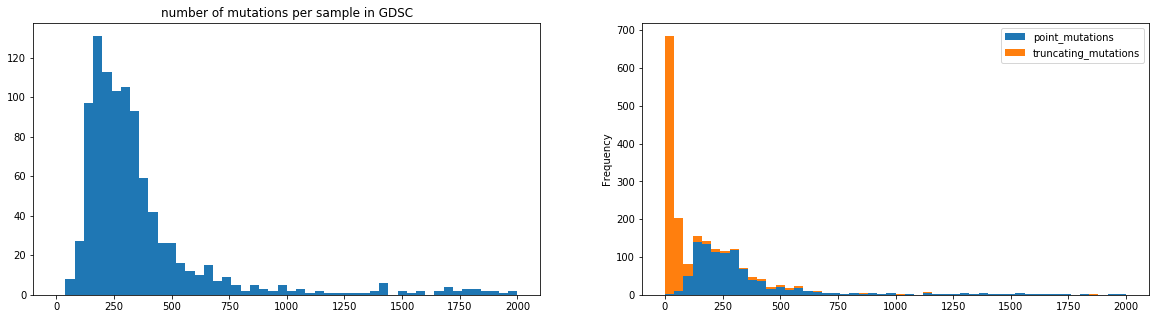

In [14]:
# define functional effect of a mutation 
gdsc_truncating = ['frameshift','nonsense','stop_lost','ess_splice']
gdsc_point = ['missense','Missense','inframe']
gdsc.loc[gdsc["Classification"].isin(gdsc_truncating),"function"] = "truncating_mutation"
gdsc.loc[gdsc["Classification"].isin(gdsc_point),"function"] = "point_mutation"
gdsc = gdsc.loc[gdsc["Classification"].isin(gdsc_truncating+gdsc_point),:]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
n_mutations_gdsc = gdsc.groupby("COSMIC_ID").size().sort_values(ascending = False)
tmp = plt.hist(n_mutations_gdsc, bins=50,range = (0,2000))
tmp = plt.title("number of mutations per sample in GDSC")
ax = plt.subplot(1,2,2)
n_LoF = gdsc.loc[gdsc["Classification"].isin(gdsc_truncating ),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
n_GoF = gdsc.loc[gdsc["Classification"].isin(gdsc_point),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
df = pd.DataFrame.from_dict({"truncating_mutations":n_LoF,"point_mutations":n_GoF})
#tmp = plt.hist(n_LoF, bins=50)
#tmp = plt.title("LoF mutations per sample in GDSC")
df.plot.hist(stacked = True, bins = 50,ax =ax,range = (0,2000))
print("mean",round(np.mean(n_mutations_gdsc),1), "median",np.median(n_mutations_gdsc))


In [28]:
def binarize(x):
    if x==0:
        return x
    else:
        return 1

def get_aa_pos_GDSC(x):
    l = re.findall(r'\d+', x)
    if len(l) == 0:
        #print(x, "positions not found.",file = sys.stderr)
        return ("NA","NA")
    elif len(l) == 1:
        return (int(l[0]), int(l[0]))
    else:
        return (int(l[0]), int(l[1]))

In [15]:

gdsc["aa_pos"] = gdsc["AA"].apply(lambda x : get_aa_pos_GDSC(x))
#gdsc["start"] = gdsc["aa_pos"].apply(lambda x : x.split(",")[0])
#gdsc["end"] = gdsc["aa_pos"].apply(lambda x : x.split(",")[1])
gdsc.head(5)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)"
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)"
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)"
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)"
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)"


In [16]:
ensg_genes = []
symbols = []
for gene in set(gdsc["Gene"].values):
    if gene.startswith("ENSG"):
        ensg_genes.append(gene)
        
    else:
        symbols.append(gene)
print("ENSEMBL gene IDs found:",len(ensg_genes))
ensg_genes = gdsc.loc[gdsc["Gene"].isin(ensg_genes), :]
gdsc_hugo =  gdsc.loc[gdsc["Gene"].isin(symbols), :]
print("Gene symbols:",len(set(gdsc_hugo["Gene"].values)))

ENSEMBL gene IDs found: 101
Gene symbols: 18989


In [17]:
# mapping to Entrez
df = gdsc_hugo[["Gene"]].copy()
df.set_index("Gene",drop= False ,inplace=True)
df.drop_duplicates(inplace = True)
df, query2target,not_mapped  = apply_mappers(df, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")

Mapped: 18509 
	directly via main_mapper 17003 
	via alternative mapper 452 
	via one of multiple synonyms in alternative mapper 1029 
	LOC 25 
Unmapped: 480 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 51 
	LOC not found in Entrez 11 
	Not found at all: 418


/home/olya/miniconda2/lib/python2.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
IDs mapped to multiple target IDs are kept:
 [143872, 23272, 341019, 27177, 387119, 84530, 26165, 11321, 122945, 150082, 2122, 442444, 79949, 157777, 340578, 100289124, 8805, 127602, 387707, 728194, 345222, 84108, 91283, 84631, 388761, 4253, 163486, 54438, 92017, 283310, 84148, 57018, 284352, 5315, 283849, 339669, 119016, 340204, 64753, 64760, 25849, 286464, 129285, 4360, 10507, 4883, 23334, 114984, 256815, 23345, 57662, 165186, 93081, 54617, 84316, 200030, 10592, 57705, 246126, 126321, 10613, 374, 79741, 51586, 144535, 728642, 168850, 647060, 284565, 63895, 201625, 29086, 1954, 9127, 29099, 941, 155066, 140733, 85452, 139728, 84458, 55719, 23028, 2459

In [18]:
gdsc_hugo = gdsc_hugo.loc[~gdsc_hugo["Gene"].isin(not_mapped),:].copy()
gdsc_hugo["Entrez_gene_ID"] = gdsc_hugo["Gene"].apply(lambda x : query2target[x])
gdsc_hugo.head(10)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos,Entrez_gene_ID
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)",1
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)",1
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)",1
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)",1
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)",1
5,909698,A1BG,p.R90H,missense,point_mutation,"(90, 90)",1
6,905971,A1BG,p.T46M,missense,point_mutation,"(46, 46)",1
7,909761,A1BG,p.P41fs*33,frameshift,truncating_mutation,"(41, 33)",1
8,1327769,A1BG,p.E249D,missense,point_mutation,"(249, 249)",1
9,1330931,A1BG,p.Y184*,nonsense,truncating_mutation,"(184, 184)",1


In [19]:
gdsc_scores = {}
for sample in list(set(gdsc_hugo["COSMIC_ID"].values)):
    df = gdsc_hugo.loc[gdsc_hugo["COSMIC_ID"] == sample,:]
    gdsc_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
gdsc_scores = pd.DataFrame.from_dict(gdsc_scores)
gdsc_scores.fillna(0,inplace=True)
#import seaborn as sns
#sns.heatmap(gdsc_scores.loc[[7157,5290,3845,2312,4893],:])
gdsc_scores.to_csv(preprocessed_dir+"/GDSC.non_bin_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,4893],:]

,683665,683667,684052,684055,684057,684059,684062,684072,684681,687448,...,1659818,1659819,1659823,1659928,1659929,1660034,1660035,1660036,1674021,1789883
7157,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,0.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.00,-1.0,-1.0
5290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.05,1.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.00,0.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.10,0.0,0.0


In [20]:

gdsc_scores = gdsc_scores.applymap(lambda x: binarize(x))
gdsc_scores.to_csv(preprocessed_dir+"/GDSC.binary_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,2312,4893],:]

,683665,683667,684052,684055,684057,684059,684062,684072,684681,687448,...,1659818,1659819,1659823,1659928,1659929,1660034,1660035,1660036,1674021,1789883
7157,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
5290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# PDX

     * gene amplifications,deletions and mutations are mixed in one file
    * gene ID - Symobols
    * some gene IDs converted to datetime format
    * mutation types: MutKnownFunctional, MutLikelyFunctional, MutNovel. Although we failed to find an explanation of the categories. 
    * 146 duplicated muataion records found (removed)


In [21]:
pdx = pd.read_excel(root_dir + "../PDX/nm.3954-S2.xlsx","pdxe_mut_and_cn2")
print(pdx.shape)
pdx.head(5)

(262091, 5)


,Sample,Gene,Entrez,Category,Details
0,X-1004,A2LD1,87769,Amp5,5.74
1,X-1004,ABCA4,24,MutNovel,"K1831N,0.550"
2,X-1004,ABCC13,150000,Amp8,8
3,X-1004,ABHD13,84945,Amp5,6.06
4,X-1004,ABTB1,80325,Amp5,6.82


In [22]:
pdx.groupby("Category").size()

Category
Amp5                    51450
Amp8                     9629
Del0.8                  77022
MutKnownFunctional      11002
MutLikelyFunctional       172
MutNovel               112816
dtype: int64

In [23]:
# remove CNA, drop duplicated records
pdx = pdx.loc[~pdx["Category"].isin(["Amp5","Amp8","Del0.8"]),:]
pdx = pdx.drop_duplicates()
print(pdx.shape)
df_size = pdx.shape[0]
# datetime genes
datetimes = pdx["Gene"].apply(lambda x : type(x) == unicode or type(x) == str)
datetimes = datetimes[~datetimes].index
pdx_ = pdx.loc[datetimes,:]
pdx_ = pdx_.loc[pdx_["Entrez"]!="None",:]
pdx_["Entrez_gene_ID"] = pdx_["Entrez"].apply(int)
pdx_["Gene"] = pdx_["Gene"].apply(str)
pdx = pdx.loc[~pdx.index.isin(datetimes),:]
print(df_size - pdx.shape[0],"gene IDs were converted to datetimes Excel.")
#pdx.head(5)

(123844, 5)
67 gene IDs were converted to datetimes Excel.


In [24]:
# annotate genes 
PDX_genes = pdx[["Gene"]].copy()
PDX_genes.drop_duplicates(inplace = True)
print("mutated genes in PDX cohort",PDX_genes.shape[0])
PDX_genes.set_index("Gene",drop=False,inplace=True)
# rename with mapper 
PDX_genes, query2target, not_mapped = apply_mappers(PDX_genes, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")
pdx = pdx.loc[~pdx["Gene"].isin(not_mapped),:]
pdx["Entrez_gene_ID"] = pdx["Gene"].apply(lambda x : query2target[x])

# keep not mapped genes with Entrez IDs provided
pdx_not_mapped = pdx.loc[pdx["Gene"].isin(not_mapped),:]
pdx_not_mapped = pdx_not_mapped.loc[pdx_not_mapped["Entrez"]!="None",:]
pdx_not_mapped["Entrez_gene_ID"] = pdx_not_mapped["Entrez"].apply(int)

# concatenate 
pdx = pd.concat([pdx,pdx_,pdx_not_mapped],axis=0)
pdx 

mutated genes in PDX cohort 15214
Mapped: 15062 
	directly via main_mapper 14107 
	via alternative mapper 249 
	via one of multiple synonyms in alternative mapper 624 
	LOC 82 
Unmapped: 152 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 31 
	LOC not found in Entrez 115 
	Not found at all: 6


IDs mapped to multiple target IDs are kept:
 [143872, 84458, 51236, 119016, 6218, 653067, 286464, 79741, 644019, 284565, 374, 144535, 341019, 84316, 4253, 200030]


,Sample,Gene,Entrez,Category,Details,Entrez_gene_ID
1,X-1004,ABCA4,24,MutNovel,"K1831N,0.550",24
8,X-1004,ADAM17,6868,MutNovel,"P799T,1.000",6868
16,X-1004,ADCK1,57143,MutNovel,"D52G,1.000",57143
17,X-1004,ADNP,23394,MutNovel,"R784T,0.223",23394
21,X-1004,AK1,203,MutNovel,"K27N,0.430",203
32,X-1004,AMOTL2,51421,MutNovel,"A578P,0.625",51421
37,X-1004,ANKRD36,375248,MutNovel,"T998S,0.278",375248
38,X-1004,ANKRD62,None,MutNovel,"N547T,1.000",342850
41,X-1004,ANXA7,310,MutNovel,"I283V,0.565",310
43,X-1004,APLF,200558,MutNovel,"I237V,0.556",200558


In [25]:
# define positions and mutation types
pdx = pdx.sort_values(["Sample","Entrez_gene_ID"])
pdx = pdx.loc[:,["Sample","Entrez_gene_ID","Details","Gene","Category"]]
pdx.head(5)

,Sample,Entrez_gene_ID,Details,Gene,Category
1,X-1004,24,"K1831N,0.550",ABCA4,MutNovel
21,X-1004,203,"K27N,0.430",AK1,MutNovel
41,X-1004,310,"I283V,0.565",ANXA7,MutNovel
52,X-1004,460,"S1091C,0.443",ASTN1,MutNovel
57,X-1004,546,"P711A,1.000",ATRX,MutNovel


In [26]:
#pdx.loc[pdx["Details"].str.contains("\-"),:].sort_values("Sample").shape
#pdx.loc[pdx["Gene"] == "TTN",:].sort_values("Sample")
#pdx.loc[pdx["Category"]=="MutLikelyFunctional",:].sort_values("Sample")

In [27]:
# guess mutation type from "Details" field
def guess_mut_type(x):
    mut = x.split(",")[0]
    missense_pattern = re.compile("^[A-Z][0-9]+[A-Z]$")
    indel_pattern = re.compile("^[A-Z]+[0-9]+[A-Z]+$")
    #stop_gain_pattern = re.compile("^[A-Z][0-9]+\*$")
    if bool(re.match(missense_pattern ,mut)): # missense
        return "missense"
    elif bool(re.match(indel_pattern ,mut)): # indel inframe
        return "inframe_indel"
    elif "*" in mut: #bool(re.match(stop_gain_pattern,mut)): 
        return "stop_gain_or_fs" #print(mut)
    elif "?" in mut: # splice_site
        return "ess_splice" #print(mut)
    elif bool(re.match(re.compile("^\-[0-9]+[A-Z]+$"),mut)): # -64Q - always MutNovel
        return "unrecognized_point"
    elif bool(re.match(re.compile("^\-[0-9]+$"),mut)): # -509 mostly MutKnownFunctional
        return "unrecognized_truncating"
    elif bool(re.match(re.compile("^[A-Z]+[0-9]+\-$"),mut)):  #Q72- mutNovel
        return "unrecognized_point2"
    else:
        return "unrecognized"
#for d in pdx["Details"].values:
    
pdx["Classification"] = pdx["Details"].apply(guess_mut_type)
#pdx.loc[pdx["Classification"].str.contains("unrecognized"),:].groupby(["Category","Classification"]).size()
pdx.groupby(["Classification"]).size().sort_values(ascending = False)
#pdx.loc[pdx["Classification"]=="unrecognized",:]

Classification
missense                   99349
inframe_indel               8559
unrecognized_truncating     4624
stop_gain_or_fs             3788
unrecognized_point2         2245
ess_splice                  2204
unrecognized_point          1643
dtype: int64

In [28]:
pdx_truncating = ['stop_gain_or_fs','ess_splice',"unrecognized_truncating"]
pdx_point = ['missense','inframe_indel','unrecognized_point','unrecognized_point2']
pdx.loc[pdx["Classification"].isin(pdx_truncating),"function"] = "truncating_mutation"
pdx.loc[pdx["Classification"].isin(pdx_point),"function"] = "point_mutation"
pdx.groupby(["function"]).size().sort_values(ascending = False)

function
point_mutation         111796
truncating_mutation     10616
dtype: int64

In [29]:
pdx["aa_change"] = pdx["Details"].apply(lambda x: x.split(",")[0])
pdx["aa_pos"] = pdx["aa_change"].apply(lambda x : get_aa_pos_GDSC(x))
pdx.head()

,Sample,Entrez_gene_ID,Details,Gene,Category,Classification,function,aa_change,aa_pos
1,X-1004,24,"K1831N,0.550",ABCA4,MutNovel,missense,point_mutation,K1831N,"(1831, 1831)"
21,X-1004,203,"K27N,0.430",AK1,MutNovel,missense,point_mutation,K27N,"(27, 27)"
41,X-1004,310,"I283V,0.565",ANXA7,MutNovel,missense,point_mutation,I283V,"(283, 283)"
52,X-1004,460,"S1091C,0.443",ASTN1,MutNovel,missense,point_mutation,S1091C,"(1091, 1091)"
57,X-1004,546,"P711A,1.000",ATRX,MutNovel,missense,point_mutation,P711A,"(711, 711)"


In [30]:
# calculate per gene scores: 
pdx_scores = {}
for sample in list(set(pdx["Sample"].values)):
    df = pdx.loc[pdx["Sample"] == sample,:]
    pdx_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
pdx_scores = pd.DataFrame.from_dict(pdx_scores)
pdx_scores.fillna(0,inplace=True)

pdx_scores.to_csv(preprocessed_dir+"/PDX.non_bin_mutations.tsv",sep = "\t")
pdx_scores.loc[[7157,5290,3845,2312,4893],:]

,X-1004,X-1008,X-1027,X-1095,X-1119,X-1156,X-1167,X-1169,X-1172,X-1173,...,X-5713,X-5717,X-5727,X-5739,X-5808,X-5959,X-5974,X-5975,X-6030,X-6047
7157,-1.0,-1.00,-1.0,0.0,0.0,-1.0,-0.5,-1.0,-1.00,0.0,...,0.0,-1.0,0.0,0.0,-1.000000,0.0,-1.0,0.0,0.0,-1.0
5290,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.00,1.0,1.0,0.0,1.0,0.0,0.0,1.00,1.0,...,0.0,1.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0
2312,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4893,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-1.0,...,0.0,0.0,-1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [31]:
pdx_scores = pdx_scores.applymap(lambda x: binarize(x))
pdx_scores.to_csv(preprocessed_dir+"/PDX.binary_mutations.tsv",sep = "\t")
pdx_scores.loc[[7157,5290,3845,2312,4893],:]

,X-1004,X-1008,X-1027,X-1095,X-1119,X-1156,X-1167,X-1169,X-1172,X-1173,...,X-5713,X-5717,X-5727,X-5739,X-5808,X-5959,X-5974,X-5975,X-6030,X-6047
7157,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2312,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TCGA and CCLE 
    * in CCLE only 1651 genes were profiled. We used the file "CCLE_hybrid_capture1650_hg19_NoCommonSNPs_CDS_2012.05.07.maf.gz" marked as recommended. It contains a list of mutations across CCLE cell lines, with VAF > 10%, and common SNP excluded. 
    wget https://data.broadinstitute.org/ccle_legacy_data/hybrid_capture_sequencing/CCLE_hybrid_capture1650_hg19_NoCommonSNPs_CDS_2012.05.07.maf.gz
    
    Other source files:
    * "List of mutations in 1651 genes, determined by targeted massively parallel sequencing combined with Raindance technology":
    wget https://data.broadinstitute.org/ccle_legacy_data/hybrid_capture_sequencing/1650_HC_plus_RD_muts.maf.annotated
    wget https://data.broadinstitute.org/ccle_legacy_data/hybrid_capture_sequencing/1650_HC_plus_RD_indels.maf.annotated
  
  
    Union contains 120 OG and 182 TSG

In [177]:
def read_broad_maf(df, point, truncating, protein_change = "Protein_Change"):
    df = df[["Hugo_Symbol","Entrez_Gene_Id","Variant_Classification",
                       protein_change,'Tumor_Sample_Barcode']].copy()
    #                    'Chromosome', u'Start_position', u'End_position']].copy()
    if "-Tumor" in df["Tumor_Sample_Barcode"].values[0]:
        df["Tumor_Sample_Barcode"] = df["Tumor_Sample_Barcode"].apply(lambda x : x.replace("-Tumor","") )
    df.sort_values(["Tumor_Sample_Barcode","Hugo_Symbol"], inplace=True)
    df = df.loc[~df["Variant_Classification"].isin(["3'UTR","5'Flank","5'UTR","Intron","Silent","RNA",
                                                    "De_novo_Start_OutOfFrame",'De_novo_Start_InFrame']),:]
    
    if df.shape[0] == 0:
        return df.rename({"Entrez_Gene_Id":"Entrez_gene_ID","Tumor_Sample_Barcode":"Sample"},axis ="columns")
    df.loc[df["Variant_Classification"].isin(truncating),"function"] = "truncating_mutation"
    df.loc[df["Variant_Classification"].isin(point),"function"] = "point_mutation"
    df.loc[df["Variant_Classification"].isin(['Splice_Site_DNP','Splice_Site_Ins','Splice_Site_SNP',
                                              'Start_Codon_Del','Stop_Codon_DNP','Stop_Codon_Ins']),"Protein_Change"] = "NA"
    
    df["aa_pos"] =  df[protein_change].apply(lambda x : get_aa_pos_GDSC(x))
    df.rename({"Entrez_Gene_Id":"Entrez_gene_ID","Tumor_Sample_Barcode":"Sample"},axis ="columns",inplace=True)
    return df

In [32]:
ccle_point = ["Missense_Mutation","In_Frame_Del","In_Frame_Ins"]
ccle_truncating = ["Frame_Shift_Del","Frame_Shift_Ins","Nonsense_Mutation",
                   "Splice_Site_Ins","Splice_Site_Del","Splice_Site_SNP","Splice_Site_DNP",
                   "Start_Codon_Del","Stop_Codon_DNP"]

ccle = pd.read_csv("../../CCLE/CCLE_hybrid_capture1650_hg19_NoCommonSNPs_CDS_2012.05.07.maf",sep="\t")
ccle = read_broad_maf(ccle, ccle_point, ccle_truncating)
ccle.head(5)

/home/olya/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Hugo_Symbol,Entrez_gene_ID,Variant_Classification,Protein_Change,Sample,function,aa_pos
76694,AAK1,22848,Missense_Mutation,p.R634H,22RV1_PROSTATE,point_mutation,"(634, 634)"
37856,ABCC4,10257,Frame_Shift_Del,p.L883fs,22RV1_PROSTATE,truncating_mutation,"(883, 883)"
27083,ACACB,32,Missense_Mutation,p.R2360H,22RV1_PROSTATE,point_mutation,"(2360, 2360)"
66125,ACVR2A,92,Frame_Shift_Del,p.K435fs,22RV1_PROSTATE,truncating_mutation,"(435, 435)"
46329,ADAMTSL3,57188,Missense_Mutation,p.G287D,22RV1_PROSTATE,point_mutation,"(287, 287)"


In [33]:
ccle.groupby("Variant_Classification").size().sort_values(ascending = False)
ccle.groupby("function").size().sort_values(ascending = False)

function
point_mutation         70503
truncating_mutation    18486
dtype: int64

In [34]:
ccle_scores = {}
for sample in list(set(ccle["Sample"].values)):
    df = ccle.loc[ccle["Sample"] == sample,:]
    ccle_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
ccle_scores = pd.DataFrame.from_dict(ccle_scores)
ccle_scores.fillna(0,inplace=True)

ccle_scores.to_csv(preprocessed_dir+"/CCLE.non_bin_mutations.tsv",sep = "\t")
ccle_scores.loc[[7157,5290,3845,4893],:]

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
7157,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,0.000000,-1.0,0.0,0.0
5290,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,1.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [35]:
ccle_scores = ccle_scores.applymap(lambda x: binarize(x))
ccle_scores.to_csv(preprocessed_dir+"/CCLE.binary_mutations.tsv",sep = "\t")
ccle_scores.loc[[7157,5290,3845,2312,4893],:]

/home/olya/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
7157,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
5290,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TCGA

### detected problems:
* no protein change field in 'KIPAN', 'OV', 'GBMLGG','COADREAD','LGG','KICH','KIRC' cohorts
* no input files for MESO
* protein change may be in fields "Protein_Change","amino_acid_change_WU","AAChange","amino_acid_change" 
* some missense mutations have no protein change.
* not clear what is 'R' protein change; these mutations excluded
* in some cohorts e.g. BRCA, Entrez_Gene_Id is 0 for all genes. We remapped HGNC symbols to Entrez Gene Id.
We skip mutations with Ensembl gene ID appeared in the column "Hugo_Symbol".

Cohorts and mutaions without protein change were excluded.

In [138]:
# remapping Hugo symbols to Entreze gene ids if necessary 
NCBI = pd.read_csv(root_dir+"Homo_sapiens.gene_info",sep = "\t")
NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")
ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 
ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")
def hgnc2entrez_mapper(df,ncbi_symbols,ncbi_synonyms):
    remapped_df = df[["Entrez_gene_ID","Hugo_Symbol"]].copy()
    remapped_df.drop_duplicates(inplace = True)
    remapped_df.set_index("Hugo_Symbol",inplace=True)
    remapped_df,query2target,not_mapped  = apply_mappers(remapped_df, ncbi_symbols, ncbi_synonyms,
                                                         verbose = False,handle_duplicates = "keep")
    if len(not_mapped) > 0 :
        print(len(not_mapped),"Hugo symbols not mapped to Entrez gene ID",not_mapped, file = sys.stderr)
        df = df.loc[~df["Hugo_Symbol"].isin(not_mapped),:].copy()
    df["Entrez_gene_ID"] = df["Hugo_Symbol"].apply(lambda x:query2target[x])
    return df

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
16 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
59266 Symbol can be mapped directly to GeneID
Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3145 Synonyms mapped to multiple GeneID
49179 different Synonyms mapped to the same GeneID
10839 Synonyms can be mapped directly to GeneID


In [172]:
cohorts = []
for f in os.listdir("../../TCGA/mutations/data/"):
    if f.endswith("tar.gz"):
        fp = f.replace(".tar.gz","")
        cohort = fp.split(".")[2].replace("org_","")
        if not cohort in ["KIPAN","OV",'GBMLGG','COADREAD','KIRC']: # 'LGG','KICH'
            cohorts.append(cohort)
print(cohorts)

['ACC', 'TGCT', 'PCPG', 'BRCA', 'CHOL', 'THYM', 'UCEC', 'SKCM', 'PRAD', 'LIHC', 'ESCA', 'CESC', 'THCA', 'DLBC', 'GBM', 'UCS', 'LAML', 'HNSC', 'PAAD', 'LUAD', 'UVM', 'SARC', 'LGG', 'STAD', 'READ', 'KICH', 'KIRP', 'LUSC', 'STES', 'COAD', 'BLCA']


In [183]:
tcga_point = ['In_Frame_Del','In_Frame_Ins','Missense_Mutation']
tcga_truncating = ['Frame_Shift_Del','Frame_Shift_Ins','Nonsense_Mutation',
                   'Splice_Site','Translation_Start_Site','Nonstop_Mutation']

vatiant_types = set()
for cohort in cohorts: 
    print(cohort)
    tcga = {}
    
    # decide which mutation file to use
    proc_maf_path = "../../TCGA/mutations/data/gdac.broadinstitute.org_"+cohort+".Mutation_Packager_Calls.Level_3.2016012800.0.0/"
    raw_maf_path = "../../TCGA/mutations/data_raw/gdac.broadinstitute.org_"+cohort+".Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/"
    proc_maf_files, raw_maf_files = 0, 0 
    if os.path.exists(processed_maf_path):
        proc_maf_files = len(os.listdir(proc_maf_path))
    if os.path.exists(raw_maf_path):
        raw_maf_files =  len(os.listdir(raw_maf_path))
    # select the one with maximal number of mutations
    print("preprocessed maf",proc_maf_files,"fies;\t\traw maf:",raw_maf_files,"files",file = sys.stderr)
    if raw_maf_files > proc_maf_files:
        path = raw_maf_path
        print("select raw maf file for cohort", cohort, file =sys.stderr )
    else:
        path = proc_maf_path
        print("select processed maf file for cohort", cohort, file =sys.stderr )
    print("use path",path, file = sys.stderr)
    for fname in os.listdir(path):
        if fname.endswith(".maf.txt"):
            #print(sname)
            df = pd.read_csv(path+fname, sep = "\t")
            sname = df["Tumor_Sample_Barcode"].values[0]
            vatiant_types = vatiant_types | set(df["Variant_Classification"].values)
            if "Protein_Change" in df.columns:
                protein_change = "Protein_Change"
            elif "amino_acid_change_WU" in df.columns:
                protein_change = "amino_acid_change_WU"
            elif "AAChange" in df.columns:
                protein_change = "AAChange"
            elif "amino_acid_change" in df.columns:
                protein_change = "amino_acid_change"
            else:
                print("Protein change columns not found in", fname, cohort,file=sys.stderr)
            df.fillna(value={protein_change:"NA"}, inplace=True)
            df = read_broad_maf(df, tcga_point, tcga_truncating, protein_change =  protein_change)
            # if all Entrez gene IDs are zeroes
            if set(df["Entrez_gene_ID"].values) == set([0]):
                # remap Hugo symbols 
                df = hgnc2entrez_mapper(df,ncbi_symbols,ncbi_synonyms)
            elif 0 in set(df["Entrez_gene_ID"].values) :
                # if zero in Entrez gene IDs, remove 
                df = df.loc[df["Entrez_gene_ID"]!=0,:]
            if df.shape[0] == 0:
                tcga[sname] = {}
            else:
                # exlued point mutations with undefined postions 
                s = df.loc[df["aa_pos"]== ("NA","NA"),:].loc[df["function"]== "point_mutation",:]
                if s.shape[0] > 0:
                    print(s[["Hugo_Symbol","Entrez_gene_ID","Variant_Classification",
                             "function",protein_change,"aa_pos"]],file = sys.stderr)
                    df = df.loc[~df.index.isin(s.index.values),:]
                    if s.shape[0] > 5:
                        print(sname, cohort,s.shape[0],"point mutations without a position",df.shape[0],"remain",file = sys.stderr)
                if df.shape[0] == 0:
                    tcga[sname] = {}
                else:
                    tcga[sname] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
    # write table
    tcga = pd.DataFrame.from_dict(tcga)
    tcga.fillna(0,inplace = True)
    tcga.to_csv(preprocessed_dir+"/TCGA-"+cohort+".non_bin_mutations.tsv",sep = "\t")
    # binarize and write
    #tcga= tcga.applymap(lambda x: binarize(x))
    #tcga.to_csv(preprocessed_dir+"/TCGA-"+cohort+".binary_mutations.tsv",sep = "\t")

ACC


preprocessed maf 91 fies;		raw maf: 0 files
select processed maf file for cohort ACC
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_ACC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
583       TINAG           27283      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
583        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
93        GPX1            2876      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
93        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
369      YTHDF3          253943      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
369        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
106        GPX1            2876      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
106        .  (NA, NA)  
   Hugo_Symb

TGCT


preprocessed maf 156 fies;		raw maf: 0 files
select processed maf file for cohort TGCT
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_TGCT.Mutation_Packager_Calls.Level_3.2016012800.0.0/
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
107      BCYRN1            6872      Missense_Mutation  point_mutation   
31        NPRL3            8131      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
107        .  (NA, NA)  
31         .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
62      TXNRD2           10587      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
62        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
47       FRG1B          284802      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
47        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
49       FRG1B          284802      Miss

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
72       FOLR3            2352      Missense_Mutation  point_mutation   
48       RRBP1            6238      Missense_Mutation  point_mutation   
73      SEPHS2           22928      Missense_Mutation  point_mutation   
74     TSPAN10           83882      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
72        .  (NA, NA)  
48        .  (NA, NA)  
73        .  (NA, NA)  
74        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
84      ZNF274           10782      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
84        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
47       OLFM2           93145      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
47        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
23           .          283685           In_Frame_I

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
8            .       100288142      Missense_Mutation  point_mutation   
43           .          440348      Missense_Mutation  point_mutation   
56           .          400986      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
8         .  (NA, NA)  
43        .  (NA, NA)  
56        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
46        EPT1           85465      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
46        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
83     FAM86B1           85002      Missense_Mutation  point_mutation   
17        NACA            4666      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
83        .  (NA, NA)  
17        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
14       PELI3          246330      Missense_Mutati

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
89      SEPHS2           22928      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
89        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
61        CHIT1            1118      Missense_Mutation  point_mutation   
519       PRKDC            5591      Missense_Mutation  point_mutation   
52     RABGAP1L            9910      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
61         .  (NA, NA)  
519        .  (NA, NA)  
52         .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
17         C1R             715      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
17        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
3            .          343170      Missense_Mutation  point_mutation   
76       SIMC1          375484      Missense_Mutation  point_mutati

PCPG


preprocessed maf 185 fies;		raw maf: 0 files
select processed maf file for cohort PCPG
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_PCPG.Mutation_Packager_Calls.Level_3.2016012800.0.0/


BRCA


preprocessed maf 983 fies;		raw maf: 0 files
select processed maf file for cohort BRCA
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_BRCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']


10 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'CSRP2BP', 'DBC1', 'TCEB3C', 'ENSG00000249624', 'MT-ATP6', 'MT-CO3', 'MT-CYB', 'MT-ND3', 'MT-ND4']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173366']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']


2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']


2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214397']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173366']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


9 Hugo symbols not mapped to Entrez gene ID ['ADC', 'AIM1', 'C15orf38', 'CCBP2', 'CD97', 'EFTUD1', 'MLL2', 'TCEB3CL', 'ENSG00000235434']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267261']


1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


2 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ODZ3']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000235041']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['APITD1']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


2 Hugo symbols not mapped to Entrez gene ID ['CCBP2', 'FLJ43860']


4 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'CSRP2BP', 'MLL4', 'ODZ3']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256349']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


3 Hugo symbols not mapped to Entrez gene ID ['PPYR1', 'TRAPPC2P1', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


3 Hugo symbols not mapped to Entrez gene ID ['MLL4', 'ODZ3', 'ENSG00000257950']


2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1

 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
3 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'MLL2', 'ENSG00000251184']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


2 Hugo symbols not mapped to Entrez gene ID ['CD97', 'FAM18B2']


5 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'DBC1', 'ODZ3', 'ENSG00000233389', 'ENSG00000237240']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257198']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'FLJ27352']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214970']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259288']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000183470']


9 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'C2orf47', 'CSRP2BP', 'MLL2', 'ODZ3', 'PPYR1', 'ENSG00000184909', 'ENSG00000187461', 'ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 

Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']
2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'ENSG00000262323']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263424']


1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258472']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'CD97']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'SLC35E2']


1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C11orf48', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


6 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'FAM18B2', 'MLL2', 'MLL4', 'ENSG00000256349', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254756']


4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MLL2', 'MLL4', 'ENSG00000258466']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'RPL17-C18ORF32']


1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247570']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260175']


1 Hugo symbols not mapped to Entrez gene ID ['HN1']


1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']


2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ODZ3']


2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'ENSG00000248710']


2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267385']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258852']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['CCBP2']


2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ENSG00000260861']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000261884']


2 Hugo symbols not mapped to Entrez gene ID ['C2orf47', 'CD97']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


3 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'ODZ3', 'ENSG00000260175']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


2 Hugo symbols not mapped to Entrez gene ID ['HN1', 'ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'TRAPPC2P1']


1 Hugo symbols not mapped to Entrez gene ID ['CCRL1']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232637']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'MLL2', 'ENSG00000254553']


1 Hugo symbols not mapped to Entrez gene ID ['ADC']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249209']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


8 Hugo symbols not mapped to Entrez gene ID ['ABP1', 'AIM1', 'C11orf48', 'C2orf47', 'MLL4', 'ENSG00000187461', 'ENSG00000240127', 'ENSG00000260175']


1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257033']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000251357']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


CHOL


preprocessed maf 36 fies;		raw maf: 0 files
select processed maf file for cohort CHOL
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_CHOL.Mutation_Packager_Calls.Level_3.2016012800.0.0/
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
226           .            1550      Missense_Mutation  point_mutation   
215       PRSS1            5644      Missense_Mutation  point_mutation   
214         ZAN            7455      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
226        .  (NA, NA)  
215        .  (NA, NA)  
214        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
211       FOLR3            2352      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
211        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
118           .          728741      Missense_Mutation  point_mutation   
132           .           30816      Missense_Mutation  po

    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
190       PCSK6            5046      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
190        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
111           .          131034      Missense_Mutation  point_mutation   
142      METTL8           79828      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
111        .  (NA, NA)  
142        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
158       MAPK6            5597      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
158        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
101           .          319089      Missense_Mutation  point_mutation   
94      FOXRED1           55572      Missense_Mutation  point_mutation   
117       SPEF2           79925      Missense_Mutation  point_mutation   

    AAC

THYM


2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260415']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']


2 Hugo symbols not mapped to Entrez gene ID ['LOC101930102', 'MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263264']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176984']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000243501', 'ENSG00000269089']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256530']


UCEC


preprocessed maf 249 fies;		raw maf: 0 files
select processed maf file for cohort UCEC
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_UCEC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


SKCM


preprocessed maf 346 fies;		raw maf: 369 files
select raw maf file for cohort SKCM
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_SKCM.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/home/olya/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (38,50,67,81,82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/olya/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (38,50,81,82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


PRAD


preprocessed maf 333 fies;		raw maf: 500 files
select raw maf file for cohort PRAD
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_PRAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/home/olya/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (38,67,81,82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


LIHC


preprocessed maf 199 fies;		raw maf: 374 files
select raw maf file for cohort LIHC
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_LIHC.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


ESCA


preprocessed maf 186 fies;		raw maf: 0 files
select processed maf file for cohort ESCA
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_ESCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237452', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268194']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100509091']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000228768', 'ENSG00000232748']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000145965', 'ENSG00000242628', 'ENSG00000257743']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205018', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255537', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


7 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'AZI1', 'ENSG00000212999', 'ENSG00000249428', 'ENSG00000260415', 'ENSG00000267848', 'ENSG00000268241']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232866']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']


4 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000212857', 'ENSG00000268059', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101928664']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811', 'ENSG00000267848', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000231171', 'ENSG00000263020']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000228532']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'ENSG00000257743', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254469', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'ENSG00000268948']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'MT-ND5', 'MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000254614', 'MT-CO1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000233539', 'ENSG00000268948']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267848', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000240291']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128374']


4 Hugo symbols not mapped to Entrez gene ID ['NOTCH2NL', 'ENSG00000179755', 'ENSG00000267848', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'ENSG00000255641', 'ENSG00000268241']


2 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000183154']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000205018']


1 Hugo symbols not mapped to Entrez gene ID ['101928757']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


2 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101928102']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'ENSG00000269175']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'ENSG00000215642']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267270', 'FLJ22184']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']


12 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ENSG00000183154', 'ENSG00000212857', 'ENSG00000215428', 'ENSG00000225996', 'ENSG00000237102', 'ENSG00000255622', 'ENSG00000257743', 'ENSG00000259455', 'ENSG00000267270', 'ENSG00000268467', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215304', 'ENSG00000232274', 'MT-ATP8']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234677']


3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000237452', 'ENSG00000268467']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215642']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000259455']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031', 'ENSG00000268864', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'MT-ATP6', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


3 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000173213', 'ENSG00000255835']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'ENSG00000225996', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268400', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259357', 'ENSG00000272268']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267954']


3 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101927810']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255154', 'ENSG00000259471']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272268']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000181495', 'ENSG00000255537']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247925']


4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000183562', 'ENSG00000217825', 'MT-ATP6']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'LOC100133301', 'ENSG00000205018']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217702', 'ENSG00000234222', 'MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214999']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214305']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000212928', 'ENSG00000259966']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000249428', 'ENSG00000255622']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000169203', 'ENSG00000212857', 'ENSG00000253251']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248801', 'ENSG00000257057', 'ENSG00000264222']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253172', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226524', 'ENSG00000259455', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['HN1L']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217825']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269490']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ46361']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101930611']


4 Hugo symbols not mapped to Entrez gene ID ['LOC100996779', 'ENSG00000217825', 'ENSG00000267848', 'ENSG00000269175']


CESC


preprocessed maf 195 fies;		raw maf: 0 files
select processed maf file for cohort CESC
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_CESC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


THCA


preprocessed maf 405 fies;		raw maf: 505 files
select raw maf file for cohort THCA
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_THCA.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


1 Hugo symbols not mapped to Entrez gene ID ['RP11-113D6.10']


DLBC


preprocessed maf 49 fies;		raw maf: 0 files
select processed maf file for cohort DLBC
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_DLBC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


GBM


preprocessed maf 291 fies;		raw maf: 291 files
select processed maf file for cohort GBM
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_GBM.Mutation_Packager_Calls.Level_3.2016012800.0.0/


UCS


preprocessed maf 58 fies;		raw maf: 0 files
select processed maf file for cohort UCS
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_UCS.Mutation_Packager_Calls.Level_3.2016012800.0.0/


LAML


preprocessed maf 198 fies;		raw maf: 0 files
select processed maf file for cohort LAML
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_LAML.Mutation_Packager_Calls.Level_3.2016012800.0.0/
1 Hugo symbols not mapped to Entrez gene ID ['LOC100132232']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
18        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
18      in_frame_ins  (NA, NA)  
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['uc004amh.1']
4 Hugo symbols not mapped to Entrez gene ID ['LOC100130734', 'LOC100132903', 'LOC387761', 'LOC727878']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100131040']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216522']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128077']


1 Hugo symbols not mapped to Entrez gene ID ['uc002rsf.1']


1 Hugo symbols not mapped to Entrez gene ID ['LOC728896']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['LOC727895']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
3 Hugo symbols not mapped to Entrez gene ID ['MT-ND1', 'MT-ND4', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['PRG-3', 'ENSG00000211619']
2 Hugo symbols not mapped to Entrez gene ID ['NOTCH2NL', 'LOC200493']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100129901']


4 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'LOC100132800', 'LOC100133684', 'MT-CO3']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'LOC730032']


2 Hugo symbols not mapped to Entrez gene ID ['LOC100129218', 'ENSG00000103832']
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
2        FLT3            2322           In_Frame_Ins  point_mutation   

  amino_acid_change    aa_pos  
2      in_frame_ins  (NA, NA)  


2 Hugo symbols not mapped to Entrez gene ID ['LOC644504', 'ENSG00000214135']


2 Hugo symbols not mapped to Entrez gene ID ['LOC100132713', 'LOC100134687']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
16      in_frame_ins  (NA, NA)  


2 Hugo symbols not mapped to Entrez gene ID ['FLJ43860', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ND5', 'uc001vvs.1']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
16      in_frame_ins  (NA, NA)  


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000198229']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000211894']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO3']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100133915']
2

 Hugo symbols not mapped to Entrez gene ID ['LOC100133718', 'LOC730167']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133292']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215720', 'ENSG00000220279']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128371']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000124399']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22167']
1

 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']
3 Hugo symbols not mapped to Entrez gene ID ['ODZ3', 'LOC100128989', 'LOC100129218']
1 Hugo symbols not mapped to Entrez gene ID ['LOC257039']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100133655']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100132495']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100131699']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100132800']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000163098']


1 Hugo symbols not mapped to Entrez gene ID ['LOC644992']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO3', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['uc004ewl.1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000204989']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND2']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['PRAMEF16']
1

HNSC


 Hugo symbols not mapped to Entrez gene ID ['LOC100128744']
preprocessed maf 280 fies;		raw maf: 513 files
select raw maf file for cohort HNSC
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_HNSC.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


PAAD


preprocessed maf 151 fies;		raw maf: 186 files
select raw maf file for cohort PAAD
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_PAAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


LUAD


preprocessed maf 231 fies;		raw maf: 544 files
select raw maf file for cohort LUAD
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_LUAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


UVM


preprocessed maf 81 fies;		raw maf: 0 files
select processed maf file for cohort UVM
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_UVM.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
10        REC8            9985      Missense_Mutation  point_mutation   

   Protein_Change    aa_pos  
10             NA  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
17        TEP1            7011      Missense_Mutation  point_mutation   

   Protein_Change    aa_pos  
17             NA  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16       ABCB4            5244      Missense_Mutation  point_mutation   

   Protein_Change    aa_pos  
16             NA  (NA, NA)  
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
7       AP1G2            8906      Missense_Mutation  point_mutation   

  Protein_Change    aa_pos  
7        

   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
13      KATNB1           10300      Missense_Mutation  point_mutation   

   Protein_Change    aa_pos  
13             NA  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
21      SEMA5A            9037      Missense_Mutation  point_mutation   
3        TNPO3           23534      Missense_Mutation  point_mutation   

   Protein_Change    aa_pos  
21             NA  (NA, NA)  
3              NA  (NA, NA)  
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
6        PKP3           11187      Missense_Mutation  point_mutation   

  Protein_Change    aa_pos  
6             NA  (NA, NA)  


SARC


preprocessed maf 248 fies;		raw maf: 0 files
select processed maf file for cohort SARC
use path ../../TCGA/mutations/data/gdac.broadinstitute.org_SARC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234978', 'ENSG00000269688', 'ENSG00000272231']


8 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000205821', 'ENSG00000221136', 'ENSG00000222717', 'ENSG00000261616', 'ENSG00000270726', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000250992']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000203849']


4 Hugo symbols not mapped to Entrez gene ID ['DH17', 'ENSG00000215958', 'ENSG00000237357', 'MT-RNR2']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221704', 'ENSG00000258727']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000230850']


3 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'DH7', 'ENSG00000185710']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'T10']


4 Hugo symbols not mapped to Entrez gene ID ['CAC2D1', 'DH11', 'ENSG00000215398', 'ENSG00000234719']


3 Hugo symbols not mapped to Entrez gene ID ['CHR9', 'ENSG00000215958', 'ENSG00000237452']


5 Hugo symbols not mapped to Entrez gene ID ['DJA4', 'EM', 'ENSG00000268673', 'PSB', 'SP91']
6 Hugo symbols not mapped to Entrez gene ID ['LOC100507033', 'ENSG00000267219', 'ENSG00000269939', 'ENSG00000273433', 'MT-ATP8', 'PEPLD']


5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000206567', 'ENSG00000221280', 'ENSG00000226716', 'ENSG00000265803', 'ENSG00000268823']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000262712']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221741', 'ENSG00000222586', 'T10']
2 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'ENSG00000221295']


5 Hugo symbols not mapped to Entrez gene ID ['ALAD2', 'CNTP3', 'ENSG00000215979', 'ENSG00000221659', 'ENSG00000259241']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000252677']
3 

Hugo symbols not mapped to Entrez gene ID ['ENSG00000214614', 'MT-CO1', 'MT-RNR2']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'DJC1', 'ENSG00000225946']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221704']


7 Hugo symbols not mapped to Entrez gene ID ['DH2', 'ENSG00000201913', 'ENSG00000214581', 'ENSG00000215022', 'ENSG00000221295', 'ENSG00000221388', 'ENSG00000272667']


5 Hugo symbols not mapped to Entrez gene ID ['LOC101930494', 'DH2', 'DJB3', 'KC5', 'ST6GALC4']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000237281', 'ENSG00000265002']


5 Hugo symbols not mapped to Entrez gene ID ['EB1BP2', 'ENSG00000223697', 'ENSG00000256616', 'ENSG00000270726', 'PLX2']


4 Hugo symbols not mapped to Entrez gene ID ['DH10', 'ENSG00000221684', 'ENSG00000264299', 'ENSG00000266657']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000196589', 'ENSG00000221235', 'ENSG00000254551', 'ENSG00000255200']


4 Hugo symbols not mapped to Entrez gene ID ['GT1', 'CAC1S', 'ENSG00000232274', 'ENSG00000253200']


5 Hugo symbols not mapped to Entrez gene ID ['LOC100293748', 'ENSG00000161103', 'ENSG00000227175', 'ENSG00000233207', 'IFR1']
3 Hugo symbols not mapped to Entrez gene ID ['DH2', 'FLJ46361', 'RG2']
3 Hugo symbols not mapped to Entrez gene ID ['APC4', 'ENSG00000251199', 'ENSG00000265194']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221684', 'ENSG00000256616']


9 Hugo symbols not mapped to Entrez gene ID ['AHK2', 'CAC1A', 'ENSG00000203849', 'ENSG00000215923', 'ENSG00000215954', 'ENSG00000224643', 'ENSG00000233825', 'ENSG00000258437', 'ENSG00000266999']
3 Hugo symbols not mapped to Entrez gene ID ['CSGALCT1', 'DJB3', 'RG2']


5 Hugo symbols not mapped to Entrez gene ID ['LOC101928102', 'DH11', 'ENSG00000221011', 'ENSG00000234978', 'ENSG00000267260']
3 Hugo symbols not mapped to Entrez gene ID ['DJB8-AS1', 'ENSG00000223063', 'ENSG00000267045']


4 Hugo symbols not mapped to Entrez gene ID ['CAC2D4', 'ENSG00000235852', 'ENSG00000236911', 'MT-RNR1']


7 Hugo symbols not mapped to Entrez gene ID ['CAC1E', 'ENSG00000205745', 'ENSG00000221280', 'ENSG00000259455', 'ENSG00000269939', 'FLJ26850', 'SI3']


6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'CNTP3B', 'ENSG00000204398', 'ENSG00000244306', 'ENSG00000256982', 'ENSG00000263378']


21 Hugo symbols not mapped to Entrez gene ID ['CAC1S', 'DH10', 'DH17', 'DH6', 'DH7', 'ENSG00000188477', 'ENSG00000189275', 'ENSG00000205663', 'ENSG00000215958', 'ENSG00000221137', 'ENSG00000221379', 'ENSG00000234722', 'ENSG00000235772', 'ENSG00000237265', 'ENSG00000256982', 'ENSG00000257057', 'ENSG00000257829', 'ENSG00000260628', 'ENSG00000267943', 'KP2', 'RSEL']


3 Hugo symbols not mapped to Entrez gene ID ['LOC101928703', 'ENSG00000216020', 'ENSG00000221279']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CAC1C', 'ENSG00000200485']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000196096', 'ENSG00000244327']
2 Hugo symbols not mapped to Entrez gene ID ['DH7', 'RSE8']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258727']


5 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CNTP3', 'ENSG00000221395', 'ENSG00000266885', 'ENSG00000267040']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216194']


6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'ENSG00000228436', 'ENSG00000228532', 'ENSG00000229743', 'ENSG00000260628', 'ENSG00000260973']
2

 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089', 'LINC00846']
5 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'DH2', 'ENSG00000161103', 'ENSG00000221544', 'ENSG00000269690']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221664', 'ENSG00000227175', 'R5-8SP6']
8 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'ENSG00000171658', 'ENSG00000212939', 'ENSG00000215527', 'ENSG00000249149', 'ENSG00000257769', 'ENSG00000257931', 'ENSG00000261759']
1

 Hugo symbols not mapped to Entrez gene ID ['APC1']
4 Hugo symbols not mapped to Entrez gene ID ['CAC1B', 'DH5', 'ENSG00000255487', 'GZ']


2 Hugo symbols not mapped to Entrez gene ID ['DJC11', 'RSE2']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216004', 'ENSG00000233434', 'ENSG00000240253']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258704']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765', 'ENSG00000231345', 'ENSG00000250910', 'ENSG00000267075']
2 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'ENSG00000188971']


3 Hugo symbols not mapped to Entrez gene ID ['LOC101928729', 'ENSG00000263120', 'ENSG00000267353']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221492', 'ENSG00000244227']


4 Hugo symbols not mapped to Entrez gene ID ['CGB', 'ENSG00000239179', 'MT-RNR2', 'MT-TL1']


3 Hugo symbols not mapped to Entrez gene ID ['CHR4', 'ENSG00000226668', 'ENSG00000261546']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101928780', 'DJC13', 'ENSG00000248115', 'ENSG00000268032']


9 Hugo symbols not mapped to Entrez gene ID ['ADC', 'CTN2', 'ENSG00000242474', 'ENSG00000254665', 'ENSG00000255384', 'ENSG00000260213', 'ENSG00000267387', 'FLJ22184', 'TIG']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000225241']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212768', 'ENSG00000221121', 'ENSG00000233836', 'R5-8SP6']


3 Hugo symbols not mapped to Entrez gene ID ['DH3', 'DH5', 'NMT3']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1G', 'ENSG00000203849', 'MT-RNR2']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216020', 'ENSG00000226145', 'ENSG00000258364']


2 Hugo symbols not mapped to Entrez gene ID ['AHK', 'AHK2']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000211996', 'ENSG00000214581', 'ENSG00000234222']


3 Hugo symbols not mapped to Entrez gene ID ['DJC13', 'ENSG00000221810', 'ENSG00000273192']


6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216191', 'ENSG00000218416', 'ENSG00000221280', 'ENSG00000233863', 'ENSG00000260411', 'PLX2']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221118', 'ENSG00000226232', 'ENSG00000268301']
1

 Hugo symbols not mapped to Entrez gene ID ['AHK2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221684', 'P1L3']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000236233', 'ENSG00000270012']
5 Hugo symbols not mapped to Entrez gene ID ['APC1', 'ENSG00000216191', 'ENSG00000228302', 'MT-CO1', 'MT-TS2']


5 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'ENSG00000205746', 'ENSG00000216113', 'ENSG00000269243', 'MT-CO1']


9 Hugo symbols not mapped to Entrez gene ID ['TCEB3CL', 'CAC1G', 'DH8', 'DJC22', 'ENSG00000221104', 'ENSG00000226738', 'ENSG00000242111', 'ENSG00000259037', 'KC1']
1 Hugo symbols not mapped to Entrez gene ID ['CAC1A']


51 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101930008', 'LOC440157', 'CA', 'CAC1C-AS1', 'CAC1D', 'CAC1S', 'CAC2D1', 'CNTP2', 'CTN2', 'DH14', 'DH3', 'DH5', 'DH6', 'DH7', 'DJB13', 'DJB3', 'DJC13', 'EH', 'ENSG00000188477', 'ENSG00000203849', 'ENSG00000219926', 'ENSG00000221653', 'ENSG00000225261', 'ENSG00000227175', 'ENSG00000228980', 'ENSG00000231171', 'ENSG00000231512', 'ENSG00000232274', 'ENSG00000234810', 'ENSG00000234921', 'ENSG00000235772', 'ENSG00000235881', 'ENSG00000250026', 'ENSG00000251273', 'ENSG00000251429', 'ENSG00000258559', 'ENSG00000260874', 'ENSG00000261720', 'ENSG00000267575', 'ENSG00000269352', 'ENSG00000269495', 'ENSG00000269533', 'ENSG00000272084', 'ENSG00000273189', 'FLJ33360', 'MGC34034', 'PLX2', 'SERPI3', 'SP91', 'V3']


9 Hugo symbols not mapped to Entrez gene ID ['DH7', 'ENSG00000224363', 'ENSG00000237452', 'ENSG00000245156', 'ENSG00000252258', 'ENSG00000257434', 'KP3', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000271894']


7 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'CHR9', 'DJC8', 'ENSG00000187695', 'ENSG00000230333', 'ENSG00000257057', 'ENSG00000272231']


4 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'ENSG00000254553', 'ENSG00000257743', 'ENSG00000271959']


6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205918', 'ENSG00000216054', 'ENSG00000226145', 'ENSG00000264576', 'GI2', 'MT-RNR1']


6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000215067', 'ENSG00000215933', 'ENSG00000221096', 'ENSG00000238737', 'ENSG00000251226']
5 Hugo symbols not mapped to Entrez gene ID ['LOC100128374', 'DH14', 'ENSG00000215941', 'ENSG00000236295', 'ENSG00000272356']


3 Hugo symbols not mapped to Entrez gene ID ['101928757', 'ENSG00000216073', 'ENSG00000221281']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000213132', 'ENSG00000234722']


4 Hugo symbols not mapped to Entrez gene ID ['LOC100293748', 'ENSG00000216113', 'ENSG00000221684', 'MT-RNR2']


5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215972', 'ENSG00000227082', 'ENSG00000250186', 'ENSG00000273433', 'IF16']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226113', 'ENSG00000266060', 'MT-RNR1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000203849', 'MT-ND5', 'MT-RNR2']


5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000223291', 'ENSG00000243175', 'ENSG00000261393', 'ENSG00000272885']


5 Hugo symbols not mapped to Entrez gene ID ['LOC101060604', 'DJC13', 'EH', 'ENSG00000249149', 'ENSG00000264057']


7 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954', 'ENSG00000221280', 'ENSG00000222732', 'ENSG00000256249', 'ENSG00000265289', 'ENSG00000271959', 'MT-RNR2']


11 Hugo symbols not mapped to Entrez gene ID ['CTN2', 'DH8', 'ENSG00000180458', 'ENSG00000215933', 'ENSG00000221279', 'ENSG00000221317', 'ENSG00000221388', 'ENSG00000221664', 'ENSG00000251966', 'ENSG00000257395', 'ENSG00000259241']
5 Hugo symbols not mapped to Entrez gene ID

 ['ENSG00000221319', 'ENSG00000237234', 'ENSG00000238411', 'ENSG00000268985', 'GLU']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1S', 'ENSG00000215953', 'ENSG00000268032']


5 Hugo symbols not mapped to Entrez gene ID ['CNTP4', 'ENSG00000227082', 'ENSG00000259605', 'ENSG00000268573', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['CTN2', 'ENSG00000262903']


6 Hugo symbols not mapped to Entrez gene ID ['DH12', 'ENSG00000216191', 'ENSG00000229481', 'ENSG00000259455', 'ENSG00000259966', 'I']


3 Hugo symbols not mapped to Entrez gene ID ['LOC100996870', '101928757', 'DH10']


8 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'DH11', 'ENSG00000224631', 'ENSG00000230615', 'ENSG00000232274', 'ENSG00000245330', 'ENSG00000268032', 'ST6GALC3']


5 Hugo symbols not mapped to Entrez gene ID ['LOC100507033', 'DH7', 'ENSG00000222033', 'ENSG00000260628', 'ENSG00000272913']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263120', 'ENSG00000268812']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000244227']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216127', 'ENSG00000221395', 'ENSG00000265209', 'ENSG00000267801']
3

 Hugo symbols not mapped to Entrez gene ID ['DH14', 'ENSG00000249237', 'FLJ40448']
11 Hugo symbols not mapped to Entrez gene ID ['GL', 'DF5', 'ENSG00000184774', 'ENSG00000203849', 'ENSG00000216173', 'ENSG00000221279', 'ENSG00000221388', 'ENSG00000224516', 'ENSG00000251273', 'MT-TY', 'TSRE1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234613', 'ENSG00000237452', 'SERPI10']


2 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000273199']


2 Hugo symbols not mapped to Entrez gene ID ['CAC1D', 'ENSG00000215958']


2 Hugo symbols not mapped to Entrez gene ID ['LOC101928787', 'MT-RNR1']
2 

Hugo symbols not mapped to Entrez gene ID ['DH9', 'FLJ41200']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221810', 'ENSG00000259455', 'ENSG00000269890', 'ENSG00000273312', 'KIAA1045']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101928921', 'DH6', 'ENSG00000221145', 'ENSG00000248115']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234978']


5 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'ENSG00000183154', 'ENSG00000233002', 'ENSG00000254990', 'ENSG00000259668']


7 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000197210', 'ENSG00000226145', 'ENSG00000231611', 'ENSG00000255384', 'FLJ45139', 'IF8']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000245482']


8 Hugo symbols not mapped to Entrez gene ID ['LOC101927648', 'LOC101930657', 'AHK2', 'CNTP2', 'ENSG00000215933', 'ENSG00000215953', 'ENSG00000259521', 'ENSG00000267865']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216166', 'ENSG00000232274', 'ENSG00000261351']


4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'DH2', 'DI2', 'ENSG00000268366']
1 Hugo symbols not mapped to Entrez gene ID ['CHR4']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205215', 'ENSG00000268081', 'ENSG00000269688', 'ENSG00000272485', 'MT-RNR2']


2 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'ENSG00000256616']
1 Hugo symbols not mapped to Entrez gene ID ['A40']


5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229047', 'ENSG00000238009', 'ENSG00000244151', 'ENSG00000255641', 'KC5']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ20444']


8 Hugo symbols not mapped to Entrez gene ID ['LOC101928921', 'DAF3', 'DJA3', 'ENSG00000204398', 'ENSG00000214105', 'ENSG00000229953', 'ENSG00000249430', 'MT-CO1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212952', 'ENSG00000221591', 'FLJ40448']
2 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000272231']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232274', 'ENSG00000235999']


6 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'CNTP5', 'ENSG00000166104', 'ENSG00000177699', 'ENSG00000215346', 'ENSG00000272231']


1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221664', 'ENSG00000239012', 'MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['IF1']


6 Hugo symbols not mapped to Entrez gene ID ['CD97', 'DJB11', 'ENSG00000229852', 'ENSG00000271828', 'RSE10', 'V3']


5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089', 'ENSG00000237452', 'ENSG00000254592', 'ENSG00000257743', 'ENSG00000267660']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954']
4 Hugo symbols not mapped to Entrez gene ID ['CNTP4', 'ENSG00000228506', 'PLX3', 'RSET2']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'DH5', 'ENSG00000221244', 'ENSG00000251226']
5

 Hugo symbols not mapped to Entrez gene ID ['GS', 'ENSG00000227175', 'ENSG00000232274', 'ENSG00000273000', 'ST6GALC5']
4 Hugo symbols not mapped to Entrez gene ID ['AHK2', 'DH8', 'ENSG00000204792', 'ENSG00000226849']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000179253', 'ENSG00000232274', 'ENSG00000257434', 'ENSG00000267601']


3 Hugo symbols not mapped to Entrez gene ID ['CHR7', 'ENSG00000201913', 'ENSG00000227407']


9 Hugo symbols not mapped to Entrez gene ID ['LOC101929948', 'ALAD2', 'CAC1B', 'CAC1F', 'DH11', 'DH6', 'DH9', 'ENSG00000223164', 'IF14']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927091', 'ENSG00000167765', 'ENSG00000253629', 'ENSG00000263120']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000264542', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257433']
3 Hugo symbols not mapped to Entrez gene ID ['DH11', 'DH6', 'ENSG00000253381']


5 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH14', 'ENSG00000185710', 'ENSG00000215941', 'RSEK']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'IF17']


12 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'AHK', 'CSPG4P8', 'ENSG00000215941', 'ENSG00000221672', 'ENSG00000223200', 'ENSG00000228463', 'ENSG00000236233', 'ENSG00000261238', 'ENSG00000266535', 'ENSG00000268889', 'V3']


3 Hugo symbols not mapped to Entrez gene ID ['BP2', 'ENSG00000264151', 'ST6GALC3']
3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'DI2', 'SERPI11']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221415', 'ENSG00000270433']


3 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000226145', 'ENSG00000272231']


18 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AHK2', 'CAC1F', 'CSGALCT1', 'CTN2', 'DH9', 'DJC17', 'DJC24', 'DK2', 'ENSG00000188474', 'ENSG00000204038', 'ENSG00000221664', 'ENSG00000223579', 'ENSG00000232675', 'ENSG00000252176', 'ENSG00000272625', 'FLJ27255', 'KC5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000223730', 'MT-RNR2']


6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'DJC5B', 'ENSG00000221684', 'ENSG00000254553', 'MIR3118-6', 'MT-TF']
2 Hugo symbols not mapped to Entrez gene ID 

['CAC1B', 'ENSG00000272231']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222032', 'ENSG00000234277', 'ENSG00000251273', 'RSEL']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000215976']


1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']


4 Hugo symbols not mapped to Entrez gene ID ['CNTP2', 'DJC13', 'ENSG00000236432', 'ENSG00000264164']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184566', 'ENSG00000216154', 'ENSG00000230615', 'ENSG00000270726']


8 Hugo symbols not mapped to Entrez gene ID ['LOC100128374', 'AHK2', 'CAC1B', 'CAC1I', 'ENSG00000226145', 'ENSG00000242288', 'ENSG00000254967', 'FLJ44006']


1 Hugo symbols not mapped to Entrez gene ID ['KC1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214397', 'FLJ46361']


3 Hugo symbols not mapped to Entrez gene ID ['DH17', 'ENSG00000200294', 'ENSG00000221732']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000224505', 'PLX2']


1 Hugo symbols not mapped to Entrez gene ID ['CNTP3']
4 Hugo symbols not mapped to Entrez gene ID ['LOC440157', 'DJB2', 'ENSG00000215933', 'ENSG00000221474']


6 Hugo symbols not mapped to Entrez gene ID ['CAC1I', 'ENSG00000203849', 'ENSG00000221121', 'ENSG00000221281', 'ENSG00000232274', 'ENSG00000267943']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954', 'ENSG00000230615']


2 Hugo symbols not mapped to Entrez gene ID ['DH17', 'ENSG00000265002']


6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000218739', 'ENSG00000221279', 'ENSG00000221280', 'ENSG00000221307', 'ENSG00000255193', 'KC1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272231', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000265865']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267075', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['DH8', 'ENSG00000221684']


4 Hugo symbols not mapped to Entrez gene ID ['DH3', 'ENSG00000221696', 'ENSG00000258944', 'ENSG00000268366']


3 Hugo symbols not mapped to Entrez gene ID ['A60', 'CTN2', 'DH7']


3 Hugo symbols not mapped to Entrez gene ID ['CTN3', 'DH5', 'ENSG00000263120']


1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']


7 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH8', 'ENSG00000211510', 'ENSG00000215941', 'ENSG00000221388', 'IF1', 'KC3']


5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'DH6', 'ENSG00000251273', 'ENSG00000259241', 'ENSG00000267260']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221672', 'ENSG00000221704', 'R5-8SP6']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221280', 'ENSG00000233002', 'ENSG00000244306', 'MT-ND6']


6 Hugo symbols not mapped to Entrez gene ID ['DH17-AS1', 'DH2', 'ENSG00000205018', 'ENSG00000215941', 'ENSG00000258661', 'ENSG00000264222']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259241']


11 Hugo symbols not mapped to Entrez gene ID ['AHK', 'CHR3', 'DH17', 'ENSG00000204038', 'ENSG00000232274', 'ENSG00000233145', 'ENSG00000242539', 'ENSG00000244306', 'ENSG00000257042', 'ENSG00000273433', 'PLX1']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000221664', 'ENSG00000231486', 'ENSG00000259479']


5 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CAC1G', 'CNTP3', 'ENSG00000222717', 'ENSG00000228980']
6 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000221219', 'ENSG00000221307', 'ENSG00000250026', 'ENSG00000270726', 'MT-RNR1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249275', 'KATL1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000227719', 'ENSG00000264299']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216116', 'ENSG00000254913', 'ENSG00000263606']


3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'ENSG00000266490', 'ENSG00000269988']


92 Hugo symbols not mapped to Entrez gene ID ['ADC', 'PA', 'PSA', 'STRA13', 'LOC100996735', 'LOC101929518', '101928757', 'AHK', 'AHK2', 'BACH1-IT1', 'CA', 'CAC1A', 'CAC1E', 'CAC1I', 'CAC1S', 'CAC2D3', 'CHR9', 'CTN3', 'DF5', 'DH10', 'DH11', 'DH17', 'DH5', 'DH8', 'DH9', 'DJB8', 'DSE1L2', 'EB1BP2', 'ENSG00000166104', 'ENSG00000173213', 'ENSG00000177553', 'ENSG00000182873', 'ENSG00000184566', 'ENSG00000187812', 'ENSG00000204038', 'ENSG00000205018', 'ENSG00000207187', 'ENSG00000215023', 'ENSG00000221335', 'ENSG00000224113', 'ENSG00000224631', 'ENSG00000225891', 'ENSG00000228998', 'ENSG00000229839', 'ENSG00000230578', 'ENSG00000230615', 'ENSG00000231437', 'ENSG00000234232', 'ENSG00000234978', 'ENSG00000235881', 'ENSG00000238129', 'ENSG00000239674', 'ENSG00000240401', 'ENSG00000247121', 'ENSG00000249502', 'ENSG00000250046', 'ENSG00000254551', 'ENSG00000254571', 'ENSG00000254815', 'ENSG00000254844', 'ENSG00000255200', 'ENSG00000256209', 'ENSG00000257494', 'ENSG00000258017', 'ENSG00000259426', 

2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253334', 'LCN']


25 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'GS', 'CAC1E', 'CNTP5', 'CTN1', 'DAF1', 'DH17', 'DJC10', 'ENSG00000187812', 'ENSG00000203496', 'ENSG00000203849', 'ENSG00000223804', 'ENSG00000233487', 'ENSG00000237265', 'ENSG00000249509', 'ENSG00000258908', 'ENSG00000261759', 'ENSG00000265002', 'ENSG00000266817', 'ENSG00000267561', 'ENSG00000269895', 'ENSG00000271959', 'FLJ46361', 'SERPI1', 'ST6GALC1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221734', 'ENSG00000255622', 'ENSG00000261200']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216102', 'R5-8SP6']


3 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ENSG00000261720', 'ENSG00000267749']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221280', 'ENSG00000267075']


5 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000221281', 'ENSG00000265002', 'ENSG00000268845', 'LCN']


3 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'DH10', 'ENSG00000221388']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237357', 'ENSG00000266156']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927958', 'DJC8', 'ENSG00000262112', 'KIAA1804']


4 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'CHR5', 'DH9', 'ENSG00000207207']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257434']


3 Hugo symbols not mapped to Entrez gene ID ['LOC101930284', 'ENSG00000203849', 'ENSG00000221156']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'KC4', 'MT-RNR2']


6 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'DH8', 'ENSG00000204398', 'ENSG00000244227', 'ENSG00000258973', 'ENSG00000266008']


8 Hugo symbols not mapped to Entrez gene ID ['GS', 'ENSG00000258364', 'ENSG00000260628', 'MT-RNR1', 'MT-RNR2', 'MT-TC', 'MT-TF', 'SP91']


6 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000220256', 'ENSG00000229481', 'ENSG00000244227', 'ENSG00000260158', 'ENSG00000267260']


2 Hugo symbols not mapped to Entrez gene ID ['DH3', 'ENSG00000235704']


34 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'LOC101929676', 'AHK', 'CAC1C-AS1', 'CNTP4', 'DH2', 'DH3', 'DH5', 'DH7', 'DH8', 'DH9', 'DJB11', 'DJB3', 'DJC1', 'ENSG00000161103', 'ENSG00000162947', 'ENSG00000204044', 'ENSG00000204957', 'ENSG00000205830', 'ENSG00000222961', 'ENSG00000228318', 'ENSG00000228829', 'ENSG00000229481', 'ENSG00000231933', 'ENSG00000239636', 'ENSG00000242590', 'ENSG00000249494', 'ENSG00000252868', 'ENSG00000257434', 'ENSG00000259069', 'ENSG00000263826', 'ENSG00000272373', 'SERPI4', 'SI1']


6 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000207207', 'ENSG00000237031', 'ENSG00000237281', 'ENSG00000263272', 'ENSG00000267462']


8 Hugo symbols not mapped to Entrez gene ID ['DH8', 'ENSG00000215923', 'ENSG00000221672', 'ENSG00000222043', 'ENSG00000225946', 'ENSG00000226145', 'ENSG00000254967', 'PLX2']


5 Hugo symbols not mapped to Entrez gene ID ['AHK', 'CHR4', 'ENSG00000221186', 'ENSG00000235837', 'ENSG00000270540']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259241', 'MT-CO1', 'MT-ND5']
4 Hugo symbols not mapped to Entrez gene ID ['AHK', 'ENSG00000206195', 'ENSG00000225411', 'ENSG00000273312']


LGG


preprocessed maf 287 fies;		raw maf: 531 files
select raw maf file for cohort LGG
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_LGG.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


STAD


preprocessed maf 290 fies;		raw maf: 396 files
select raw maf file for cohort STAD
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_STAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214999', 'ENSG00000255641']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ND5', 'MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['C11orf48']


2 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000181495']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000251606']


1 Hugo symbols not mapped to Entrez gene ID ['AGPAT9']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269808']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000269175', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


2 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000267882']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']


2 Hugo symbols not mapped to Entrez gene ID ['LOC100996735', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000212884']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189332']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['101928757']


2 Hugo symbols not mapped to Entrez gene ID ['101928757', 'ENSG00000180574']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'KIAA1045']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'CXXC11', '101928757', 'ENSG00000269808', 'KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000267360', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000241720']


3 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ENSG00000205821', 'ENSG00000253917']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000228532']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']


4 Hugo symbols not mapped to Entrez gene ID ['NAT6', 'ENSG00000255622', 'ENSG00000273398', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


2 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000187461']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197604', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267970']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000219492']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000240040']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255641']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474', 'ENSG00000255641']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000227091', 'ENSG00000255622', 'ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255641', 'ENSG00000259966']


2 Hugo symbols not mapped to Entrez gene ID ['SLC35E2', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000228532', 'MT-CO1']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000197604', 'ENSG00000232600']


2 Hugo symbols not mapped to Entrez gene ID ['ADC', '101928757']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'MT-ATP6']


4 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CXXC11', 'ENSG00000260007', 'PRAMEF16']


1 Hugo symbols not mapped to Entrez gene ID ['C11orf48']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'ENSG00000249034']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269657']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']


10 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'EFTUD1', 'FAM21A', '101928757', 'ENSG00000181495', 'ENSG00000212884', 'ENSG00000259455', 'ENSG00000263065', 'ENSG00000267561', 'KIAA1804']


7 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C10orf2', 'EFTUD1', 'FAM21A', 'TRAPPC2P1', 'ENSG00000228532', 'ENSG00000273398']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


2 Hugo symbols not mapped to Entrez gene ID ['CD97', 'NOTCH2NL']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000236432']


7 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'FAM21A', 'ENSG00000180574', 'ENSG00000219492', 'ENSG00000237568', 'ENSG00000269175', 'ENSG00000269657']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


3 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'CSRP2BP', 'ENSG00000273398']


1 Hugo symbols not mapped to Entrez gene ID ['NAT6']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'KIAA1045']


3 Hugo symbols not mapped to Entrez gene ID ['NAT6', 'ENSG00000141979', 'ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


8 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CXXC11', 'SLC35E2', 'LOC101929271', 'ENSG00000173213', 'ENSG00000255622', 'ENSG00000268241', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258654']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'ENSG00000267954', 'MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['C11orf48', 'ENSG00000212884', 'ENSG00000234719', 'KIAA1045']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000255470']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574', 'ENSG00000268412', 'KIAA1804', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000266956']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'ENSG00000269175']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'CD97', 'ENSG00000254230']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000206532']


3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'FAM21A', 'TCEB3C']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000243696', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000180574', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000261711']


2 Hugo symbols not mapped to Entrez gene ID ['LOC100996735', 'ENSG00000259455']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C10orf2', 'ENSG00000243501', 'ENSG00000255168', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['101928757']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000250850', 'ENSG00000267976']


2 Hugo symbols not mapped to Entrez gene ID ['CD97', 'EFTUD1']


1 Hugo symbols not mapped to Entrez gene ID ['TRAPPC2P1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND4L']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000250692']


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'LOC101927016', '101928503']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
1

 Hugo symbols not mapped to Entrez gene ID ['LOC101927016']


1 Hugo symbols not mapped to Entrez gene ID ['HN1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000243501']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269175', 'MT-ND5']


5 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'EFTUD1', '101928503', 'ENSG00000249034', 'ENSG00000268467']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000121388']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269846']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811']


2 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MT-ND6']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']


4 Hugo symbols not mapped to Entrez gene ID ['CD97', 'CSRP2BP', 'ENSG00000259966', 'ENSG00000269175']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000273398', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']


7 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'CSRP2BP', 'NAT6', '101928757', 'ENSG00000255622', 'KIAA1045']


2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000269175', 'MT-ATP6']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['APITD1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', '101928757']


1 Hugo symbols not mapped to Entrez gene ID ['ADC']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


5 Hugo symbols not mapped to Entrez gene ID ['ADC', 'FAM21A', 'SLC35E2', 'ENSG00000234719', 'ENSG00000255168']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000244558', 'ENSG00000255182']


4 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000255168', 'ENSG00000268412', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258654', 'MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000255641']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189332']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272822']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000243008']


1 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP']


2 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP']


READ


preprocessed maf 70 fies;		raw maf: 123 files
select raw maf file for cohort READ
use path ../../TCGA/mutations/data_raw/gdac.broadinstitute.org_READ.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
Protein change columns not found in TCGA-CI-6619-01.maf.txt READ


KeyError: "['AAChange'] not in index"

In [ ]:
vatiant_types 

In [ ]:
tcga.loc[[7157,5925,5290,4893],:]